In [1]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

c:\Users\markham\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
test_data = pd.read_csv('data\processed_articles_V8.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(',')))
stop_words = set(stopwords.words('english'))
stop_words_list = [ 'china','usa','us','america','american','americans','chinese','china','russia','russian','putin','vladimir','trump','donald','biden','joe','ukraine','ukrainian','ukrainians','ukraines','ukraine','say','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','mon','tue','wed','thu','fri','sat','sun','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december','today','yesterday','tomorrow','week','month','year','time','day','weekend','morning','afternoon','evening','night','news','new','news']
list_numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand','million','billion','trillion']
stop_words.update(stop_words_list)
stop_words.update(list_numbers)
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word != 'nan']))
test_data['content_tokens'] = test_data['content'].apply(lambda x: x.split())
test_data

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\markham\AppData\Local\Temp\ipykernel_22660\2373772370.py:1: SyntaxWarning: invalid escape sequence '\p'
  test_data = pd.read_csv('data\processed_articles_V8.csv')


,date,content,content_tokens
653,2018-12-31,mattis exit tell military keep faith countrywa...,"[mattis, exit, tell, military, keep, faith, co..."
571,2018-12-31,democrats manoeuvre end shutdown wall moneywas...,"[democrats, manoeuvre, end, shutdown, wall, mo..."
544,2018-12-31,frenchman nasri complete west ham move doping ...,"[frenchman, nasri, complete, west, ham, move, ..."
5,2018-12-31,apartment block blast kill dozen miss agencymo...,"[apartment, block, blast, kill, dozen, miss, a..."
609,2018-12-31,wall street rise limp finish line turbulent ye...,"[wall, street, rise, limp, finish, line, turbu..."
...,...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...,"[south, korea, kdb, sign, deal, hyundai, heavy..."
1838,2019-01-31,fifth asian cup title would major step japan y...,"[fifth, asian, cup, title, would, major, step,..."
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...,"[mediacoal, india, talk, gail, ioc, coal, bed,..."
1833,2019-01-31,modi see appease voter put reform aside budget...,"[modi, see, appease, voter, put, reform, aside..."


In [3]:
# Step 2: Train Word2Vec model on tokenized words
model = Word2Vec(sentences=test_data['content_tokens'], vector_size=50, window=9, min_count=4, workers=8)

# Step 3: Define sentiment-related seed words
positive_seed_words = ["joy", "success", "hope", "love", "peace", "progress", "victory", "happiness", "inspire", "trust"]
negative_seed_words = ["fear", "failure", "hate", "chaos", "decline", "loss", "anger", "despair", "betrayal", "crisis"]

# Filter seed words to ensure they are in the model's vocabulary
positive_seed_words = [word for word in positive_seed_words if word in model.wv]
negative_seed_words = [word for word in negative_seed_words if word in model.wv]

if not positive_seed_words or not negative_seed_words:
    print("Warning: Some seed words are not in the model's vocabulary. Check vocabulary or data.")

# Step 4: Precompute TF-IDF weights for the vocabulary
corpus = test_data['content'].tolist()  # Use space-separated strings for TF-IDF
vectorizer = TfidfVectorizer(vocabulary=model.wv.index_to_key)
tfidf_matrix = vectorizer.fit_transform(corpus)
word2tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# Step 5: Precompute similarity to seed words for efficiency
word_similarities = {}
for word in model.wv.index_to_key:
    pos_sim = max([model.wv.similarity(word, seed) for seed in positive_seed_words], default=0)
    neg_sim = max([model.wv.similarity(word, seed) for seed in negative_seed_words], default=0)
    word_similarities[word] = max(pos_sim, neg_sim)

# Step 6: Filter important words (top N most similar to seed words)
N = 10  # Select top 30 words per article; adjust as needed
test_data['important_words'] = test_data['content_tokens'].apply(
    lambda tokens: sorted(
        [token for token in tokens if token in word_similarities],
        key=lambda x: word_similarities[x],
        reverse=True
    )[:N]
)

# Step 7: Define a function to convert text to a weighted vector
def text_to_vector(text, model, word2tfidf):
    """Convert text to a weighted average vector using TF-IDF weights."""
    vectors = []
    weights = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
            weights.append(word2tfidf.get(word, 1.0))  # Default weight 1.0 if not in TF-IDF
    if not vectors:
        return np.zeros(model.vector_size)
    vectors = np.array(vectors)
    weights = np.array(weights) / sum(weights)  # Normalize weights
    return np.average(vectors, axis=0, weights=weights)

# Step 8: Convert important words to vectors
test_data['vector'] = test_data['important_words'].apply(lambda x: text_to_vector(x, model, word2tfidf))

# Step 9: Prepare data for clustering
X = np.array(test_data['vector'].tolist())

# Step 10: Perform clustering
num_clusters = 2  # Adjustable; you can experiment with different numbers
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)
test_data['cluster_label'] = labels


# Display the updated DataFrame
test_data

,date,content,content_tokens,important_words,vector,cluster_label
653,2018-12-31,mattis exit tell military keep faith countrywa...,"[mattis, exit, tell, military, keep, faith, co...","[anger, priority, ceremony, fast, ally, ally, ...","[0.177235798357663, 0.1939350334077955, -0.537...",0
571,2018-12-31,democrats manoeuvre end shutdown wall moneywas...,"[democrats, manoeuvre, end, shutdown, wall, mo...","[hope, son, illegal, prefer, crucial, tweet, e...","[0.06826000944756308, 0.13349638755449694, -0....",0
544,2018-12-31,frenchman nasri complete west ham move doping ...,"[frenchman, nasri, complete, west, ham, move, ...","[treatment, resume, training, appeal, switch, ...","[0.04598777588411387, 0.15578521104529486, -0....",0
5,2018-12-31,apartment block blast kill dozen miss agencymo...,"[apartment, block, blast, kill, dozen, miss, a...","[search, rubble, age, trap, similar, resident,...","[0.1437762982365849, 0.18511200978739314, -0.5...",0
609,2018-12-31,wall street rise limp finish line turbulent ye...,"[wall, street, rise, limp, finish, line, turbu...","[fear, hope, hope, progress, decline, gather, ...","[0.1482059595120624, 0.07767741141078188, -0.6...",0
...,...,...,...,...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...,"[south, korea, kdb, sign, deal, hyundai, heavy...","[approach, support, sell, park, would, local, ...","[0.4699728998962318, 0.2566184410014863, -1.58...",0
1838,2019-01-31,fifth asian cup title would major step japan y...,"[fifth, asian, cup, title, would, major, step,...","[success, victory, victory, lash, moment, hear...","[-0.05576208631930921, 0.07416149912845085, -0...",1
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...,"[mediacoal, india, talk, gail, ioc, coal, bed,...","[ioc, bed, economic, note, link, talk, coal, v...","[0.0224361166714823, 0.030732124623810978, -0....",0
1833,2019-01-31,modi see appease voter put reform aside budget...,"[modi, see, appease, voter, put, reform, aside...","[victory, nature, fast, medical, spent, youth,...","[0.0012159588105531626, 0.11585507882145869, -...",0


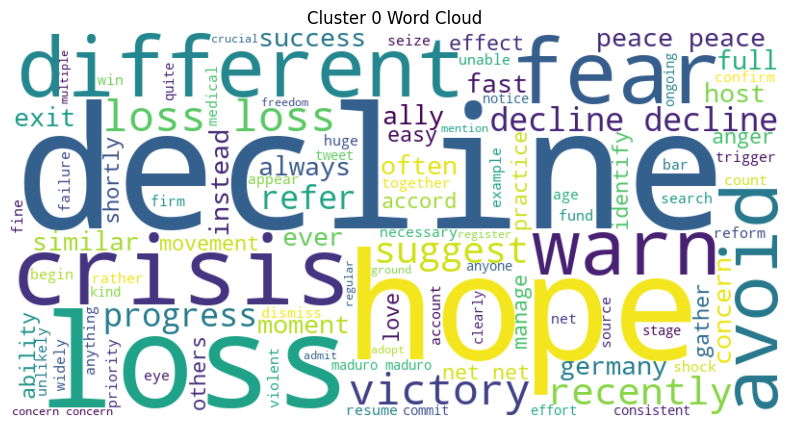

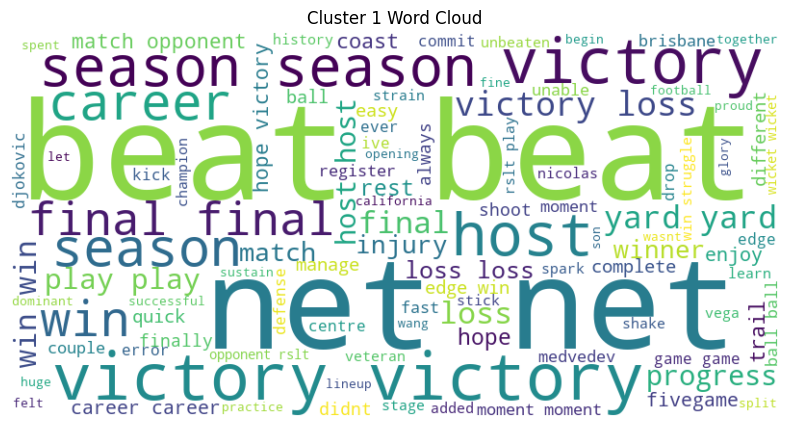

In [4]:
# Function to generate word cloud
def plot_word_cloud(text, title):
    """Generate and display a word cloud for the given text."""
    # Filter out stop words and non-alphabetic tokens
    words = ' '.join(word for word in text.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2)
    if not words.strip():
        print(f"No valid words for word cloud in {title}")
        return
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        min_font_size=10,
        stopwords=stop_words
    ).generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each cluster
for cluster in range(num_clusters):
    # Merge important_words for the cluster into a single string
    cluster_text = ' '.join([' '.join(item) for item in test_data[test_data['cluster_label'] == cluster]['important_words'].dropna()])
    if cluster_text.strip():
        plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')
    else:
        print(f"No data for Cluster {cluster} Word Cloud")

In [5]:
# Evaluate clustering effect
if 'cluster_label' in test_data and len(set(test_data['cluster_label'])) > 1:
    X = np.array(test_data['vector'].tolist())  # Assuming 'vector' is from the Word2Vec/KMeans pipeline
    labels = test_data['cluster_label'].values
    
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.3f}")
else:
    print("Unable to calculate clustering metrics: Either no 'cluster_label' column or fewer than 2 clusters.")

Silhouette Score: 0.523
Calinski-Harabasz Index: 1175.416


In [6]:
# Use VADER to analyze sentiment of important words in each cluster
# Ensure date is in datetime format (already done in your preprocessing, but confirm)
test_data['date'] = pd.to_datetime(test_data['date'])

# Group by date
grouped = test_data.groupby('date')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            # Ensure important_words is a list; if it's a string, split it
            if isinstance(important_words, str):
                words = [word for word in important_words.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            elif isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  # Skip invalid data

            if not words:
                continue  # Skip if no valid words after filtering

            text = " ".join(words)

            try:
                # Calculate sentiment scores using VADER
                sentiment = analyzer.polarity_scores(text)
                compound_score = sentiment['compound']  # Primary sentiment score
                positive_score = sentiment['pos']
                negative_score = sentiment['neg']
                neutral_score = sentiment['neu']
                sentiment_scores.append({
                    'compound': compound_score,
                    'positive': positive_score,
                    'negative': negative_score,
                    'neutral': neutral_score
                })
            except Exception as e:
                print(f"Error processing text for date {date}, cluster {cluster}: {text[:50]}..., Error: {e}")
                continue

        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'compound': np.mean([s['compound'] for s in sentiment_scores]),
                'positive': np.mean([s['positive'] for s in sentiment_scores]),
                'negative': np.mean([s['negative'] for s in sentiment_scores]),
                'neutral': np.mean([s['neutral'] for s in sentiment_scores])
            }
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': avg_sentiment['compound'],
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results:")
sentiment_df


Sentiment Analysis Results:


,date,cluster,sentiment_score,positive_score,negative_score,neutral_score,num_samples
0,2018-12-31,0,-0.101875,0.134750,0.233500,0.631750,8
1,2018-12-31,1,0.000000,0.000000,0.000000,0.000000,0
2,2019-01-01,0,0.026517,0.187889,0.163900,0.648244,90
3,2019-01-01,1,0.221032,0.264182,0.141182,0.594636,22
4,2019-01-02,0,-0.075729,0.159687,0.207487,0.632813,230
...,...,...,...,...,...,...,...
59,2019-01-29,1,-0.031140,0.090400,0.123000,0.786800,5
60,2019-01-30,0,-0.021606,0.155608,0.171316,0.673038,79
61,2019-01-30,1,-0.037243,0.116143,0.137143,0.746714,7
62,2019-01-31,0,-0.024602,0.140460,0.153508,0.706079,63


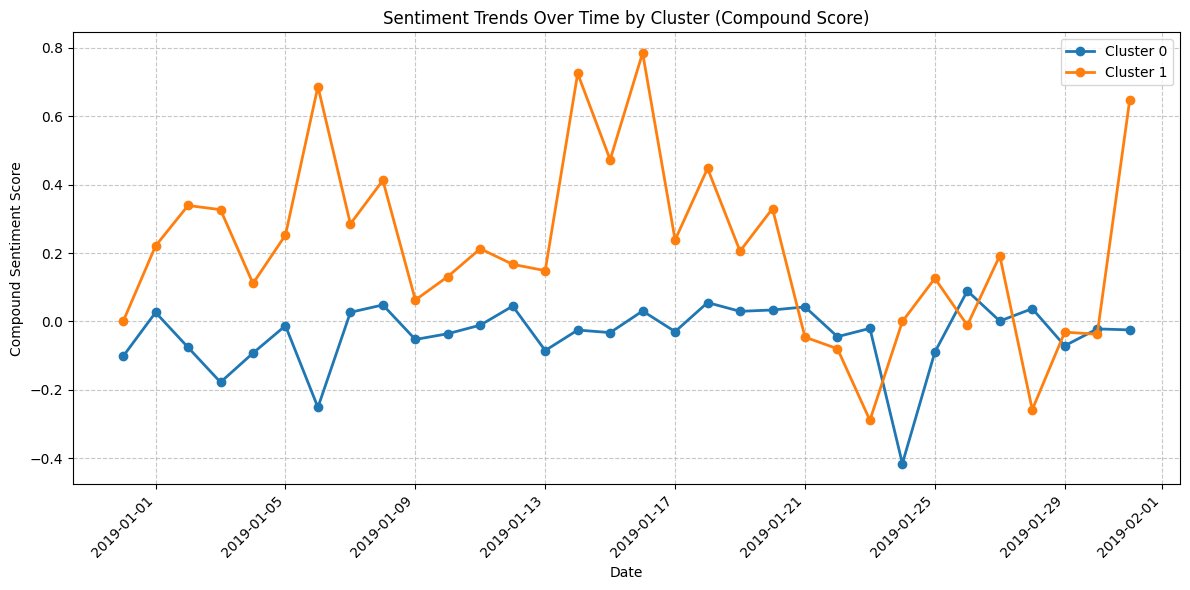

In [7]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = sentiment_df[sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker='o', linestyle='-', linewidth=2)

plt.title('Sentiment Trends Over Time by Cluster (Compound Score)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
# Use FinBERT for sentiment analysis
# Ensure date is in datetime format
test_data['date'] = pd.to_datetime(test_data['date'])

# Group by date
grouped = test_data.groupby('date')

# Define custom stop words (based on your preprocessing)
stop_words = set(stopwords.words('english'))
custom_stop_words = [
    'china', 'usa', 'us', 'america', 'american', 'americans', 'chinese', 'russia', 'russian', 'putin', 'vladimir',
    'trump', 'donald', 'biden', 'joe', 'ukraine', 'ukrainian', 'ukrainians', 'ukraines', 'say', 'jan', 'feb', 'mar',
    'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'february', 'march',
    'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'today', 'yesterday',
    'tomorrow', 'week', 'month', 'year', 'time', 'day', 'weekend', 'morning', 'afternoon', 'evening', 'night',
    'news', 'new'
]
list_numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'hundred', 'thousand', 'million', 'billion', 'trillion']
stop_words.update(custom_stop_words)
stop_words.update(list_numbers)

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"  # FinBERT model fine-tuned for financial sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline with FinBERT
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True  # Return probabilities for all labels
)

# Function to process text and get FinBERT sentiment
def get_finbert_sentiment(text, max_length=512):
    """Get sentiment scores using FinBERT, handling text truncation if necessary."""
    if not text or not isinstance(text, str):
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}
    
    # Truncate text if longer than max_length to avoid errors
    if len(text.split()) > max_length:
        text = " ".join(text.split()[:max_length])
    
    try:
        result = sentiment_analyzer(text)[0]  # Get the first (and only) result
        scores = {item['label'].lower(): item['score'] for item in result}
        # Ensure all labels (positive, negative, neutral) are present
        return {
            'positive': scores.get('positive', 0.0),
            'negative': scores.get('negative', 0.0),
            'neutral': scores.get('neutral', 0.0)
        }
    except Exception as e:
        print(f"Error processing text with FinBERT: {text[:50]}..., Error: {e}")
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}

# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            # Ensure important_words is a list; if it's a string, split it
            if isinstance(important_words, str):
                words = [word for word in important_words.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            elif isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  # Skip invalid data

            if not words:
                continue  # Skip if no valid words after filtering

            text = " ".join(words)

            # Get sentiment scores using FinBERT
            sentiment = get_finbert_sentiment(text)
            sentiment_scores.append(sentiment)

        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'positive': np.mean([s['positive'] for s in sentiment_scores]),
                'negative': np.mean([s['negative'] for s in sentiment_scores]),
                'neutral': np.mean([s['neutral'] for s in sentiment_scores])
            }
            # Calculate a compound-like score (e.g., positive - negative)
            compound_score = avg_sentiment['positive'] - avg_sentiment['negative']
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': compound_score,  # Use positive - negative as compound score
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results (FinBERT):")
print(sentiment_df)

Device set to use cpu
c:\Users\markham\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



Sentiment Analysis Results (FinBERT):
         date  cluster  sentiment_score  positive_score  negative_score  \
0  2018-12-31        0        -0.121018        0.000087        0.121105   
1  2018-12-31        1         0.000000        0.000000        0.000000   
2  2019-01-01        0        -0.050131        0.051203        0.101334   
3  2019-01-01        1         0.182187        0.367070        0.184884   
4  2019-01-02        0        -0.097789        0.094447        0.192236   
..        ...      ...              ...             ...             ...   
59 2019-01-29        1         0.374199        0.393593        0.019394   
60 2019-01-30        0        -0.154841        0.052707        0.207547   
61 2019-01-30        1         0.000916        0.147628        0.146712   
62 2019-01-31        0        -0.101313        0.063039        0.164351   
63 2019-01-31        1         0.310453        0.643808        0.333355   

    neutral_score  num_samples  
0        0.878808          

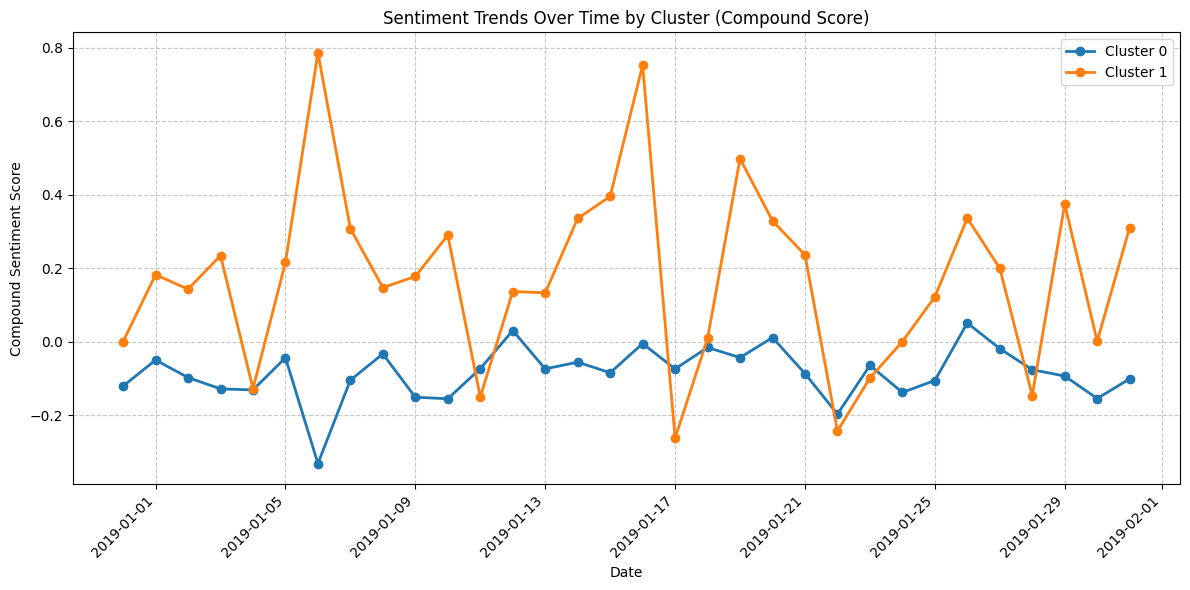

In [9]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = sentiment_df[sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker='o', linestyle='-', linewidth=2)

plt.title('Sentiment Trends Over Time by Cluster (Compound Score)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()